## Model Training

In [1]:
# ==========================================================
# 🚗 Door-State CNN — Two-Stage Training (224 → 348)
# ==========================================================
# Stage 1: 224x224 for 50 epochs (fast convergence)
# Stage 2: 348x348 for 10 epochs (fine-tuning)
# Auto-resume + auto-switch + checkpoint saving
# ==========================================================

import os, math, time, torch, shutil, re
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

# ==========================================================
# CONFIG
# ==========================================================
DATA_DIR = "dataset"   # 🔹 path to 32 folders
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS_STAGE1 = 50
EPOCHS_STAGE2 = 10
LR_STAGE1 = 1e-3
LR_STAGE2 = 1e-4
CHECKPOINT_FILE = "door_state_cnn_checkpointT4.pth"
BEST_MODEL_FILE = "door_state_cnn_bestT42STG.pth"

print(f"🖥️ Using device: {DEVICE}")

# ==========================================================
# CLEANUP
# ==========================================================
if os.path.exists(os.path.join(DATA_DIR, ".ipynb_checkpoints")):
    shutil.rmtree(os.path.join(DATA_DIR, ".ipynb_checkpoints"))
    print("🧹 Removed .ipynb_checkpoints folder.")

# ==========================================================
# DATASET
# ==========================================================
def valid_img(path):
    return path.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"))

full_dataset = datasets.ImageFolder(root=DATA_DIR, is_valid_file=valid_img)
num_classes = len(full_dataset.classes)
print(f"🧩 Found {num_classes} classes.")

# Split dataset 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(f"📦 Train: {len(train_dataset)} | Val: {len(val_dataset)}")

# ==========================================================
# MODEL
# ==========================================================
class DoorStateCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = DoorStateCNN(num_classes).to(DEVICE)

# ==========================================================
# TRAIN/VAL FUNCTIONS
# ==========================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# ==========================================================
# STAGE TRAINER
# ==========================================================
def run_training(model, img_size, lr, epochs, stage_name, start_epoch=0):
    print(f"\n🚀 Starting {stage_name} at {img_size}×{img_size} (LR={lr})")

    # Transforms
    train_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    val_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset.dataset.transform = train_tf
    val_dataset.dataset.transform = val_tf

    # DataLoader with safe fallback
    for nw in [4, 2, 0]:
        try:
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=nw, pin_memory=(nw>0))
            val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=nw, pin_memory=(nw>0))
            _ = next(iter(train_loader))
            print(f"✅ DataLoaders ready: num_workers={nw}, pin_memory={(nw>0)}")
            break
        except Exception as e:
            print(f"⚠️ DataLoader failed (workers={nw}) → {e}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=2)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    patience, patience_counter = 6, 0

    for epoch in range(start_epoch, epochs):
        start_t = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        scheduler.step(val_loss)
        elapsed = (time.time() - start_t) / 60

        print(f"[{stage_name}] Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
              f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | "
              f"Time: {elapsed:.2f} min")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_loss,
            "img_size": img_size
        }, CHECKPOINT_FILE)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), BEST_MODEL_FILE)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1}")
                break

    return model

# ==========================================================
# MAIN LOGIC
# ==========================================================
start_stage = 1
start_epoch = 0

# Resume logic
if os.path.exists(CHECKPOINT_FILE):
    ckpt = torch.load(CHECKPOINT_FILE, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    start_epoch = ckpt["epoch"] + 1
    start_img_size = ckpt.get("img_size", 224)
    start_stage = 1 if start_img_size == 224 else 2
    print(f"🔄 Resuming from epoch {start_epoch} (Stage {start_stage})")

# Stage 1
if start_stage <= 1:
    model = run_training(model, 224, LR_STAGE1, EPOCHS_STAGE1, "Stage-1", start_epoch)
    torch.save(model.state_dict(), "door_state_stage1_best.pth")
    start_stage = 2
    start_epoch = 0

# Stage 2
if start_stage <= 2:
    model.load_state_dict(torch.load(BEST_MODEL_FILE))
    model = run_training(model, 348, LR_STAGE2, EPOCHS_STAGE2, "Stage-2")

print("\n🎯 Training completed successfully!")
print(f"✅ Best model saved as: {BEST_MODEL_FILE}")

🖥️ Using device: cuda
🧩 Found 32 classes.
📦 Train: 7992 | Val: 1998
🔄 Resuming from epoch 14 (Stage 1)

🚀 Starting Stage-1 at 224×224 (LR=0.001)


/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


✅ DataLoaders ready: num_workers=4, pin_memory=True


[Stage-1] Epoch 15/50 | Train Acc: 0.662 | Val Acc: 0.107 | Train Loss: 1.011 | Val Loss: 25.646 | Time: 3.62 min


[Stage-1] Epoch 16/50 | Train Acc: 0.713 | Val Acc: 0.523 | Train Loss: 0.827 | Val Loss: 1.617 | Time: 3.63 min


[Stage-1] Epoch 17/50 | Train Acc: 0.755 | Val Acc: 0.764 | Train Loss: 0.690 | Val Loss: 0.671 | Time: 3.59 min


[Stage-1] Epoch 18/50 | Train Acc: 0.762 | Val Acc: 0.839 | Train Loss: 0.652 | Val Loss: 0.399 | Time: 3.58 min


[Stage-1] Epoch 19/50 | Train Acc: 0.786 | Val Acc: 0.819 | Train Loss: 0.564 | Val Loss: 0.485 | Time: 3.59 min


[Stage-1] Epoch 20/50 | Train Acc: 0.808 | Val Acc: 0.671 | Train Loss: 0.515 | Val Loss: 1.032 | Time: 3.63 min


[Stage-1] Epoch 21/50 | Train Acc: 0.821 | Val Acc: 0.789 | Train Loss: 0.467 | Val Loss: 0.564 | Time: 3.59 min


[Stage-1] Epoch 22/50 | Train Acc: 0.871 | Val Acc: 0.895 | Train Loss: 0.322 | Val Loss: 0.218 | Time: 3.67 min


[Stage-1] Epoch 23/50 | Train Acc: 0.880 | Val Acc: 0.898 | Train Loss: 0.292 | Val Loss: 0.208 | Time: 3.62 min


[Stage-1] Epoch 24/50 | Train Acc: 0.890 | Val Acc: 0.893 | Train Loss: 0.268 | Val Loss: 0.223 | Time: 3.60 min


[Stage-1] Epoch 25/50 | Train Acc: 0.896 | Val Acc: 0.900 | Train Loss: 0.255 | Val Loss: 0.220 | Time: 3.64 min


[Stage-1] Epoch 26/50 | Train Acc: 0.892 | Val Acc: 0.906 | Train Loss: 0.258 | Val Loss: 0.195 | Time: 3.60 min


[Stage-1] Epoch 27/50 | Train Acc: 0.906 | Val Acc: 0.896 | Train Loss: 0.230 | Val Loss: 0.222 | Time: 3.64 min


[Stage-1] Epoch 28/50 | Train Acc: 0.900 | Val Acc: 0.909 | Train Loss: 0.242 | Val Loss: 0.191 | Time: 3.65 min


[Stage-1] Epoch 29/50 | Train Acc: 0.906 | Val Acc: 0.908 | Train Loss: 0.232 | Val Loss: 0.187 | Time: 3.62 min


[Stage-1] Epoch 30/50 | Train Acc: 0.902 | Val Acc: 0.904 | Train Loss: 0.235 | Val Loss: 0.200 | Time: 3.63 min


[Stage-1] Epoch 31/50 | Train Acc: 0.912 | Val Acc: 0.912 | Train Loss: 0.211 | Val Loss: 0.194 | Time: 3.62 min


[Stage-1] Epoch 32/50 | Train Acc: 0.909 | Val Acc: 0.915 | Train Loss: 0.216 | Val Loss: 0.167 | Time: 3.65 min


[Stage-1] Epoch 33/50 | Train Acc: 0.913 | Val Acc: 0.860 | Train Loss: 0.220 | Val Loss: 0.352 | Time: 3.62 min


[Stage-1] Epoch 34/50 | Train Acc: 0.917 | Val Acc: 0.917 | Train Loss: 0.203 | Val Loss: 0.178 | Time: 3.63 min


[Stage-1] Epoch 35/50 | Train Acc: 0.917 | Val Acc: 0.910 | Train Loss: 0.207 | Val Loss: 0.194 | Time: 3.62 min


[Stage-1] Epoch 36/50 | Train Acc: 0.934 | Val Acc: 0.918 | Train Loss: 0.159 | Val Loss: 0.160 | Time: 3.62 min


[Stage-1] Epoch 37/50 | Train Acc: 0.937 | Val Acc: 0.921 | Train Loss: 0.153 | Val Loss: 0.159 | Time: 3.66 min


[Stage-1] Epoch 38/50 | Train Acc: 0.940 | Val Acc: 0.919 | Train Loss: 0.144 | Val Loss: 0.159 | Time: 3.66 min


[Stage-1] Epoch 39/50 | Train Acc: 0.940 | Val Acc: 0.915 | Train Loss: 0.147 | Val Loss: 0.165 | Time: 3.63 min


[Stage-1] Epoch 40/50 | Train Acc: 0.940 | Val Acc: 0.921 | Train Loss: 0.140 | Val Loss: 0.154 | Time: 3.64 min


[Stage-1] Epoch 41/50 | Train Acc: 0.940 | Val Acc: 0.923 | Train Loss: 0.139 | Val Loss: 0.157 | Time: 3.63 min


[Stage-1] Epoch 42/50 | Train Acc: 0.943 | Val Acc: 0.925 | Train Loss: 0.133 | Val Loss: 0.152 | Time: 3.63 min


[Stage-1] Epoch 43/50 | Train Acc: 0.939 | Val Acc: 0.924 | Train Loss: 0.144 | Val Loss: 0.153 | Time: 3.64 min


[Stage-1] Epoch 44/50 | Train Acc: 0.946 | Val Acc: 0.926 | Train Loss: 0.131 | Val Loss: 0.148 | Time: 3.59 min


[Stage-1] Epoch 45/50 | Train Acc: 0.945 | Val Acc: 0.921 | Train Loss: 0.133 | Val Loss: 0.161 | Time: 3.66 min


[Stage-1] Epoch 46/50 | Train Acc: 0.948 | Val Acc: 0.924 | Train Loss: 0.128 | Val Loss: 0.152 | Time: 3.63 min


[Stage-1] Epoch 47/50 | Train Acc: 0.948 | Val Acc: 0.920 | Train Loss: 0.123 | Val Loss: 0.153 | Time: 3.64 min


[Stage-1] Epoch 48/50 | Train Acc: 0.953 | Val Acc: 0.923 | Train Loss: 0.116 | Val Loss: 0.148 | Time: 3.66 min


[Stage-1] Epoch 49/50 | Train Acc: 0.953 | Val Acc: 0.920 | Train Loss: 0.114 | Val Loss: 0.147 | Time: 3.67 min


[Stage-1] Epoch 50/50 | Train Acc: 0.952 | Val Acc: 0.926 | Train Loss: 0.113 | Val Loss: 0.144 | Time: 3.66 min

🚀 Starting Stage-2 at 348×348 (LR=0.0001)


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

⚠️ DataLoader failed (workers=4) → DataLoader worker (pid(s) 2011) exited unexpectedly


/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


✅ DataLoaders ready: num_workers=2, pin_memory=True


[Stage-2] Epoch 1/10 | Train Acc: 0.701 | Val Acc: 0.852 | Train Loss: 1.011 | Val Loss: 0.353 | Time: 5.21 min


[Stage-2] Epoch 2/10 | Train Acc: 0.807 | Val Acc: 0.876 | Train Loss: 0.525 | Val Loss: 0.276 | Time: 5.40 min


[Stage-2] Epoch 3/10 | Train Acc: 0.844 | Val Acc: 0.888 | Train Loss: 0.423 | Val Loss: 0.246 | Time: 5.19 min


[Stage-2] Epoch 4/10 | Train Acc: 0.861 | Val Acc: 0.890 | Train Loss: 0.368 | Val Loss: 0.246 | Time: 5.12 min


[Stage-2] Epoch 5/10 | Train Acc: 0.871 | Val Acc: 0.899 | Train Loss: 0.335 | Val Loss: 0.221 | Time: 5.16 min


[Stage-2] Epoch 6/10 | Train Acc: 0.875 | Val Acc: 0.896 | Train Loss: 0.316 | Val Loss: 0.224 | Time: 5.71 min


[Stage-2] Epoch 7/10 | Train Acc: 0.880 | Val Acc: 0.896 | Train Loss: 0.296 | Val Loss: 0.219 | Time: 5.51 min


[Stage-2] Epoch 8/10 | Train Acc: 0.891 | Val Acc: 0.910 | Train Loss: 0.272 | Val Loss: 0.193 | Time: 5.15 min


[Stage-2] Epoch 9/10 | Train Acc: 0.895 | Val Acc: 0.914 | Train Loss: 0.265 | Val Loss: 0.189 | Time: 5.07 min


[Stage-2] Epoch 10/10 | Train Acc: 0.904 | Val Acc: 0.912 | Train Loss: 0.243 | Val Loss: 0.185 | Time: 5.08 min

🎯 Training completed successfully!
✅ Best model saved as: door_state_cnn_bestT42STG.pth


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

# ==========================================================
# RELOAD DATASET (same config as Stage-2)
# ==========================================================
DATA_DIR = "dataset"   # or your actual dataset path
IMG_S2 = 348
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data transforms (same as before)
val_tf = transforms.Compose([
    transforms.Resize((IMG_S2, IMG_S2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
train_tf = transforms.Compose([
    transforms.Resize((IMG_S2, IMG_S2)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_tf
val_dataset.dataset.transform = val_tf

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss()

# ==========================================================
# LOAD MODEL (same architecture)
# ==========================================================
class DoorStateCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 32)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = DoorStateCNN(num_classes=32).to(DEVICE)
model.load_state_dict(torch.load("door_state_cnn_bestT42STG.pth"))
print("✅ Loaded best Stage-2 model.")

✅ Loaded best Stage-2 model.


In [5]:
# ✅ Resume from best Stage-2 checkpoint before adaptive fine-tune
model.load_state_dict(torch.load("door_state_cnn_bestT42STG.pth"))
print("Loaded best Stage-2 model for adaptive fine-tuning.")

# Run the adaptive fine-tune block (your snippet)
# ==========================================================
# Stage-2: Adaptive Fine-Tuning with Early Stop
# ==========================================================
from torch.optim.lr_scheduler import ReduceLROnPlateau

max_initial_epochs = 10
patience = 3
lr = 1e-4
min_lr = 1e-6

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, min_lr=min_lr)

best_val_loss = float("inf")
no_improve = 0
epoch = 0
continue_training = True

print(f"\n🚀 Starting Stage-2 Adaptive Fine-Tune at 348 x 348  (LR={lr})")

while continue_training:
    epoch += 1
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"[Stage-2] Epoch {epoch:02d} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
          f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | LR: {current_lr:.2e}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "door_state_cnn_best_2STG.pth")
        print(f"💾 New best model saved! Val Loss: {best_val_loss:.4f}")
    else:
        no_improve += 1
        print(f"⚠️ No improvement ({no_improve}/{patience})")

    if no_improve >= patience:
        print("⏹️ Early stopping — no improvement in validation loss.")
        continue_training = False
    elif epoch >= max_initial_epochs + 10:
        print("⏹️ Max extended epochs reached (safety cap).")
        continue_training = False

print("✅ Stage-2 adaptive fine-tuning completed.")

Loaded best Stage-2 model for adaptive fine-tuning.

🚀 Starting Stage-2 Adaptive Fine-Tune at 348 x 348  (LR=0.0001)


[Stage-2] Epoch 01 | Train Acc: 0.897 | Val Acc: 0.936 | Train Loss: 0.256 | Val Loss: 0.149 | LR: 1.00e-04
💾 New best model saved! Val Loss: 0.1486


[Stage-2] Epoch 02 | Train Acc: 0.904 | Val Acc: 0.937 | Train Loss: 0.232 | Val Loss: 0.137 | LR: 1.00e-04
💾 New best model saved! Val Loss: 0.1365


[Stage-2] Epoch 03 | Train Acc: 0.907 | Val Acc: 0.937 | Train Loss: 0.226 | Val Loss: 0.132 | LR: 1.00e-04
💾 New best model saved! Val Loss: 0.1320


[Stage-2] Epoch 04 | Train Acc: 0.911 | Val Acc: 0.937 | Train Loss: 0.221 | Val Loss: 0.130 | LR: 1.00e-04
💾 New best model saved! Val Loss: 0.1302


[Stage-2] Epoch 05 | Train Acc: 0.910 | Val Acc: 0.934 | Train Loss: 0.212 | Val Loss: 0.139 | LR: 1.00e-04
⚠️ No improvement (1/3)


[Stage-2] Epoch 06 | Train Acc: 0.917 | Val Acc: 0.936 | Train Loss: 0.204 | Val Loss: 0.132 | LR: 1.00e-04
⚠️ No improvement (2/3)


[Stage-2] Epoch 07 | Train Acc: 0.917 | Val Acc: 0.942 | Train Loss: 0.198 | Val Loss: 0.122 | LR: 1.00e-04
💾 New best model saved! Val Loss: 0.1219


[Stage-2] Epoch 08 | Train Acc: 0.923 | Val Acc: 0.941 | Train Loss: 0.191 | Val Loss: 0.131 | LR: 1.00e-04
⚠️ No improvement (1/3)


[Stage-2] Epoch 09 | Train Acc: 0.928 | Val Acc: 0.942 | Train Loss: 0.178 | Val Loss: 0.120 | LR: 1.00e-04
💾 New best model saved! Val Loss: 0.1199


[Stage-2] Epoch 10 | Train Acc: 0.926 | Val Acc: 0.939 | Train Loss: 0.183 | Val Loss: 0.137 | LR: 1.00e-04
⚠️ No improvement (1/3)


[Stage-2] Epoch 11 | Train Acc: 0.920 | Val Acc: 0.942 | Train Loss: 0.190 | Val Loss: 0.122 | LR: 1.00e-04
⚠️ No improvement (2/3)


[Stage-2] Epoch 12 | Train Acc: 0.921 | Val Acc: 0.936 | Train Loss: 0.186 | Val Loss: 0.125 | LR: 5.00e-05
⚠️ No improvement (3/3)
⏹️ Early stopping — no improvement in validation loss.
✅ Stage-2 adaptive fine-tuning completed.


## Evaluation

In [13]:
# ==========================================================
# 🚀 Door-State Model Evaluation + Export (Stage-1 vs Stage-2)
# ==========================================================
import torch, time
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
from tqdm import tqdm
import os

# ==========================================================
# CONFIG
# ==========================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = "dataset"
BATCH_SIZE = 32
IMG_SIZE = 348  # Use validation resolution

STAGE1_MODEL = "door_state_stage1_best.pth"
STAGE2_MODEL = "door_state_cnn_best_2STG.pth"

print(f"🖥️ Using device: {DEVICE}")

# ==========================================================
# DATASET & TRANSFORMS
# ==========================================================
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder(root=DATA_DIR, transform=val_tf)
num_classes = len(val_dataset.classes)
val_size = int(0.2 * len(val_dataset))
_, val_dataset = torch.utils.data.random_split(val_dataset, [len(val_dataset)-val_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"📦 Validation set: {len(val_dataset)} images | Classes: {num_classes}")

# ==========================================================
# MODEL DEFINITION (same architecture)
# ==========================================================
class DoorStateCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# ==========================================================
# EVALUATION FUNCTION
# ==========================================================
def evaluate_model(model_path):
    model = DoorStateCNN(num_classes).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    correct, total, total_time = 0, 0, 0.0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"🔍 Evaluating {os.path.basename(model_path)}"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            start = time.time()
            outputs = model(imgs)
            total_time += (time.time() - start)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    avg_time = total_time / total
    return acc, avg_time, model

# ==========================================================
# RUN EVALUATION
# ==========================================================
stage1_acc, stage1_time, _ = evaluate_model(STAGE1_MODEL)
stage2_acc, stage2_time, best_model = evaluate_model(STAGE2_MODEL)

print(f"\n📊 Evaluation Summary:")
print(f"Stage-1 Model → Acc: {stage1_acc*100:.2f}% | Avg Inference: {stage1_time*1000:.2f} ms/frame")
print(f"Stage-2 Model → Acc: {stage2_acc*100:.2f}% | Avg Inference: {stage2_time*1000:.2f} ms/frame")

# ==========================================================
# CHOOSE BEST MODEL
# ==========================================================
final_model_path = STAGE2_MODEL if stage2_acc >= stage1_acc else STAGE1_MODEL
print(f"✅ Best model selected for export: {final_model_path}")

# ==========================================================
# EXPORT TO TORCHSCRIPT + ONNX
# ==========================================================
best_model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)

# TorchScript
traced_script = torch.jit.trace(best_model, dummy)
torch.jit.save(traced_script, "door_state_cnn_final_script.pt")
print("💾 Saved TorchScript model → door_state_cnn_final_script.pt")



🖥️ Using device: cuda
📦 Validation set: 1998 images | Classes: 32


🔍 Evaluating door_state_cnn_best_2STG.pth: 100%|██████████| 63/63 [00:49<00:00,  1.28it/s]



📊 Evaluation Summary:
Stage-1 Model → Acc: 12.61% | Avg Inference: 11.27 ms/frame
Stage-2 Model → Acc: 95.35% | Avg Inference: 10.97 ms/frame
✅ Best model selected for export: door_state_cnn_best_2STG.pth
💾 Saved TorchScript model → door_state_cnn_final_script.pt


In [14]:
best_model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)

# ✅ Export to TorchScript (offline-safe)
traced_script = torch.jit.trace(best_model, dummy)
torch.jit.save(traced_script, "door_state_cnn_final_script.pt")

print("💾 Saved TorchScript model → door_state_cnn_final_script.pt")


💾 Saved TorchScript model → door_state_cnn_final_script.pt


In [15]:
import torch
model = torch.jit.load("door_state_cnn_final_script.pt")
model.eval()

RecursiveScriptModule(
  original_name=DoorStateCNN
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=MaxPool2d)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=BatchNorm2d)
    (9): RecursiveScriptModule(original_name=Conv2d)
    (10): RecursiveScriptModule(original_name=ReLU)
    (11): RecursiveScriptModule(original_name=MaxPool2d)
    (12): RecursiveScriptModule(original_name=Conv2d)
    (13): RecursiveScriptModule(original_name=ReLU)
    (14): RecursiveScriptModule(original_name=BatchNorm2d)
    (15): RecursiveScriptModule(original_name=Conv2d)
    (16): Recursi

🧩 Using device: cuda
🔹 Loading model from door_state_cnn_final_script.pt ...
✅ TorchScript model loaded.
📦 Validation set: 9990 images | Classes: 32

✅ Validation Accuracy: 95.30%

📋 Detailed Classification Report:
                                                                                    precision    recall  f1-score   support

                                                                   s_00_all_closed      0.985     1.000     0.993        67
                                                              s_01_front_left-open      0.887     0.955     0.920        66
                                                             s_02_front_right-open      1.000     0.986     0.993        72
                                            s_03_front_left-open__front_right-open      0.970     1.000     0.985        65
                                                               s_04_rear_left-open      0.970     0.942     0.956        69
                                        

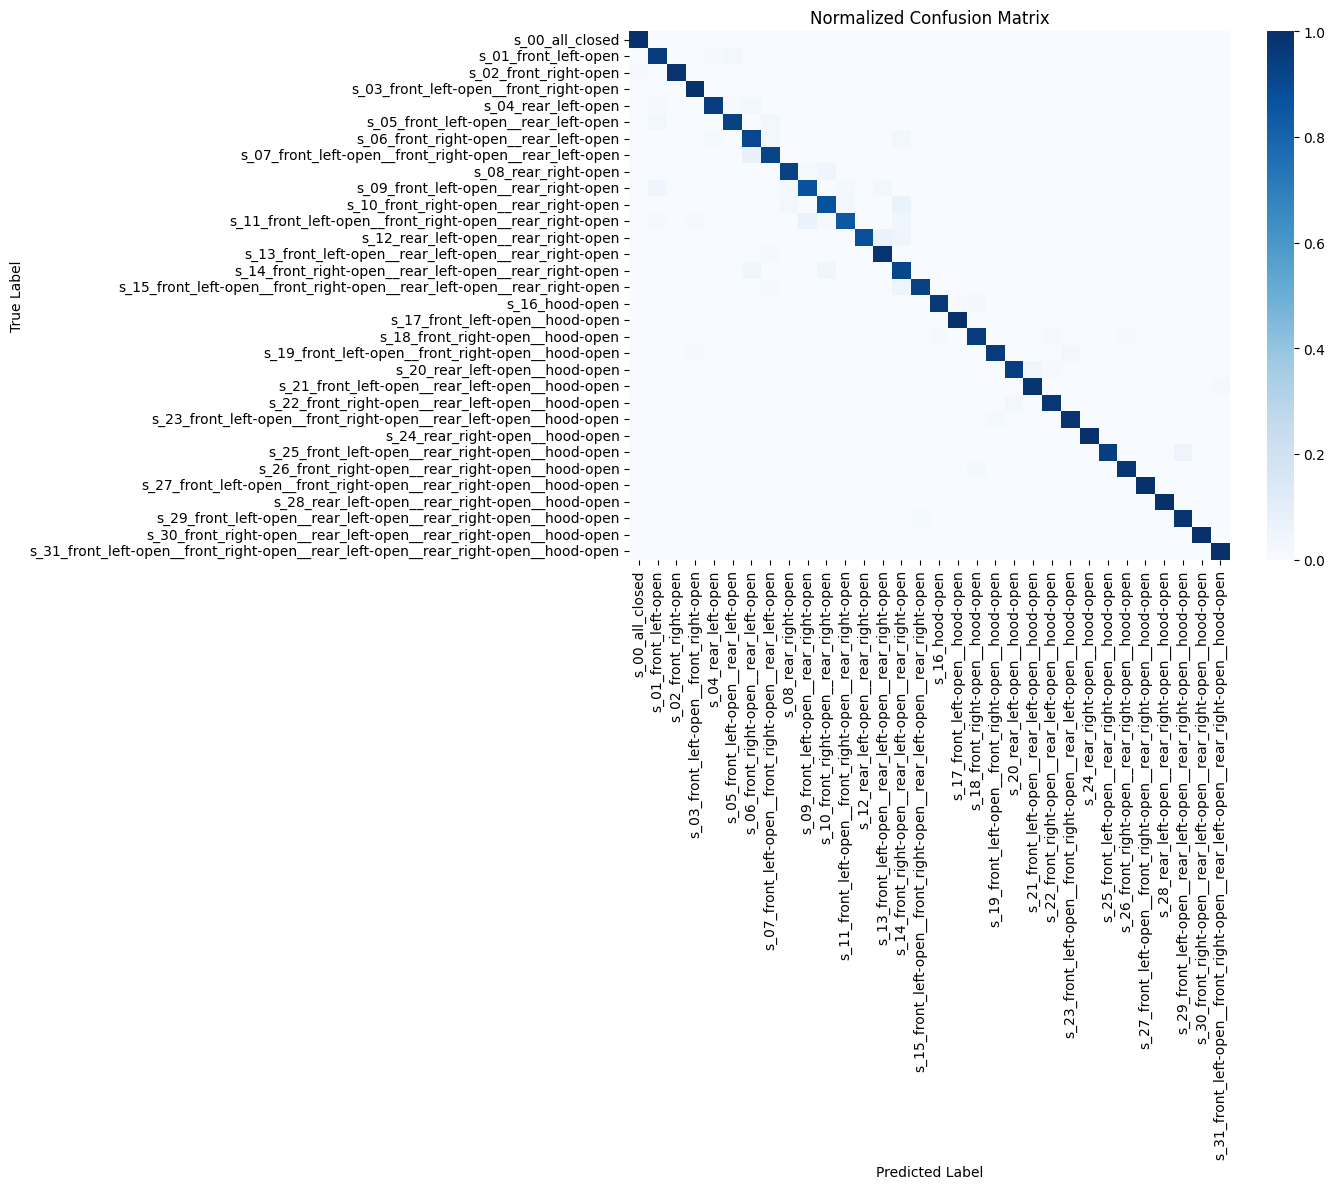


💾 Confusion matrix saved as 'confusion_matrix_doorstate.png'


In [16]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================================
# CONFIG
# ==========================================================
MODEL_PATH = "door_state_cnn_final_script.pt"
DATA_DIR = "dataset"
IMG_SIZE = 348
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🧩 Using device: {DEVICE}")

# ==========================================================
# LOAD MODEL
# ==========================================================
print(f"🔹 Loading model from {MODEL_PATH} ...")
model = torch.jit.load(MODEL_PATH, map_location=DEVICE)
model.eval()
print("✅ TorchScript model loaded.")

# ==========================================================
# DATASET
# ==========================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(dataset.classes)
print(f"📦 Validation set: {len(dataset)} images | Classes: {num_classes}")

# Split 80/20 again (same as training)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================================
# INFERENCE LOOP
# ==========================================================
all_preds, all_labels = [], []
model.to(DEVICE)

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==========================================================
# METRICS
# ==========================================================
acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f"\n✅ Validation Accuracy: {acc:.2f}%")

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes, digits=3))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_doorstate.png", dpi=300)
plt.show()

print("\n💾 Confusion matrix saved as 'confusion_matrix_doorstate.png'")

🧩 Using device: cuda
🔹 Loading model from door_state_cnn_final_script.pt ...
✅ TorchScript model loaded and ready.
📦 Validation set: 9990 images | Classes: 32

✅ Validation Accuracy: 94.74%
⚙️ Inference Performance:
   • Avg Inference Time: 12.43 ms / image
   • Fastest: 8.60 ms | Slowest: 101.66 ms
   • Approx FPS: 80.4

📋 Detailed Classification Report:
                                                                                    precision    recall  f1-score   support

                                                                   s_00_all_closed      0.982     0.982     0.982        55
                                                              s_01_front_left-open      0.923     0.923     0.923        65
                                                             s_02_front_right-open      1.000     0.983     0.991        58
                                            s_03_front_left-open__front_right-open      1.000     0.987     0.993        77
                     

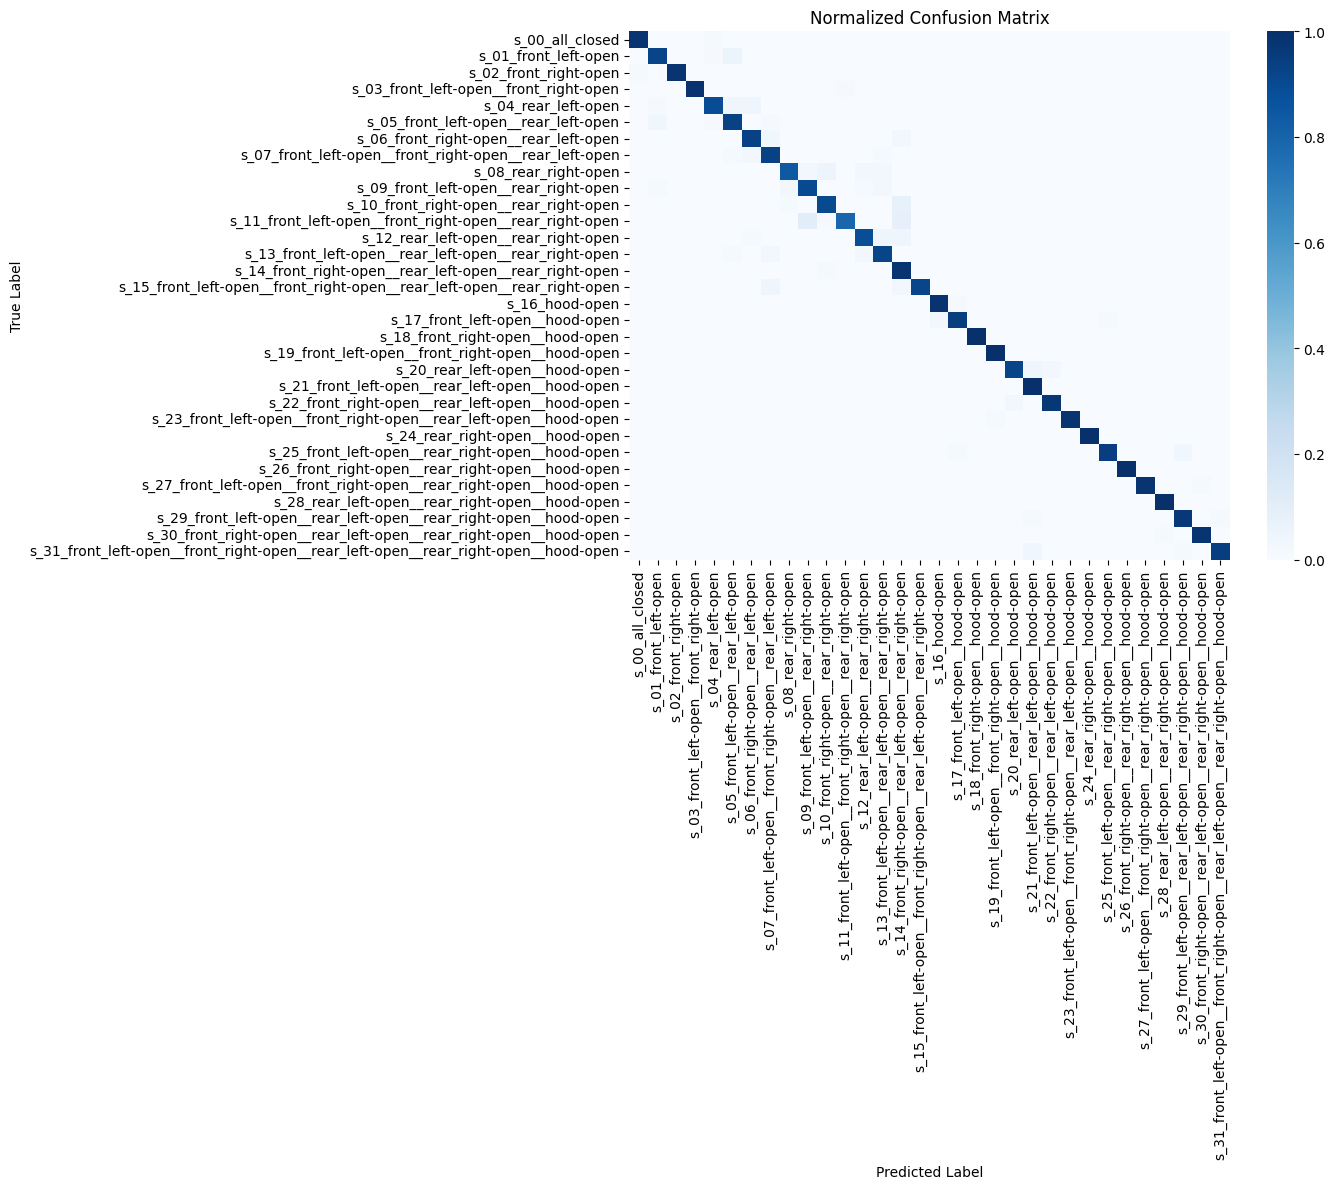


💾 Confusion matrix saved as 'confusion_matrix_doorstate_latency.png'


In [17]:
import torch, os, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================================
# CONFIG
# ==========================================================
MODEL_PATH = "door_state_cnn_final_script.pt"
DATA_DIR = "dataset"
IMG_SIZE = 348
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🧩 Using device: {DEVICE}")

# ==========================================================
# LOAD MODEL
# ==========================================================
print(f"🔹 Loading model from {MODEL_PATH} ...")
model = torch.jit.load(MODEL_PATH, map_location=DEVICE)
model.eval().to(DEVICE)
print("✅ TorchScript model loaded and ready.")

# ==========================================================
# DATASET
# ==========================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(dataset.classes)
print(f"📦 Validation set: {len(dataset)} images | Classes: {num_classes}")

# Split 80/20 again (same as training)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================================
# INFERENCE + LATENCY BENCHMARK
# ==========================================================
all_preds, all_labels = [], []
latencies = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        start_time = time.time()
        outputs = model(imgs)
        torch.cuda.synchronize() if DEVICE == "cuda" else None
        end_time = time.time()

        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        latency_batch = (end_time - start_time) / len(imgs)
        latencies.extend([latency_batch] * len(imgs))

# ==========================================================
# METRICS
# ==========================================================
acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
avg_latency = np.mean(latencies) * 1000  # in ms
min_latency = np.min(latencies) * 1000
max_latency = np.max(latencies) * 1000
fps = 1000 / avg_latency

print(f"\n✅ Validation Accuracy: {acc:.2f}%")
print(f"⚙️ Inference Performance:")
print(f"   • Avg Inference Time: {avg_latency:.2f} ms / image")
print(f"   • Fastest: {min_latency:.2f} ms | Slowest: {max_latency:.2f} ms")
print(f"   • Approx FPS: {fps:.1f}")

# ==========================================================
# CLASSIFICATION REPORT + CONFUSION MATRIX
# ==========================================================
print("\n📋 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes, digits=3))

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_doorstate_latency.png", dpi=300)
plt.show()

print("\n💾 Confusion matrix saved as 'confusion_matrix_doorstate_latency.png'")

🧩 Using device: cuda
🔹 Loading model from door_state_cnn_final_script.pt ...
✅ TorchScript model loaded and ready.
📦 Validation set: 9990 images | Classes: 32

✅ Validation Accuracy: 95.05%
⚙️ Inference Performance:
   • Avg Inference Time: 12.18 ms / image
   • Fastest: 8.35 ms | Slowest: 103.70 ms
   • Approx FPS: 82.1

📊 Per-Class Latency and Accuracy Summary:
                                                                             Class  Accuracy (%)  Avg Latency (ms)
                                                                   s_00_all_closed        100.00            11.665
                                   s_28_rear_left-open__rear_right-open__hood-open        100.00            11.529
                                 s_26_front_right-open__rear_right-open__hood-open        100.00            11.081
                                                   s_24_rear_right-open__hood-open        100.00            11.321
                 s_23_front_left-open__front_right-open__re

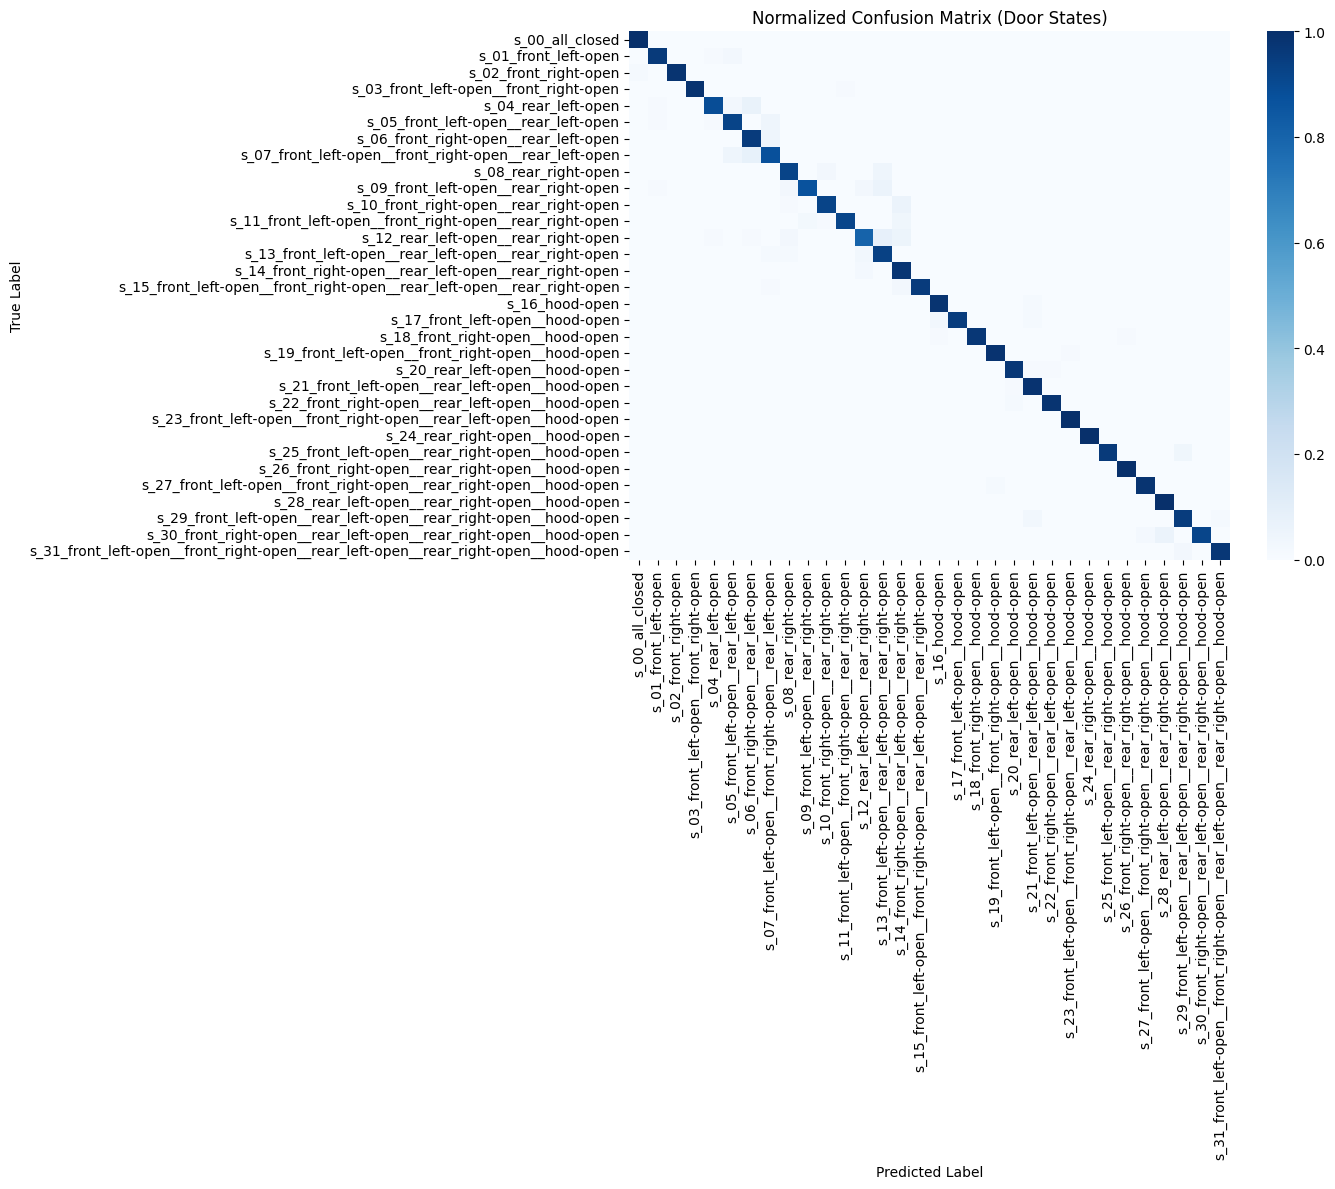


💾 Confusion matrix saved as 'confusion_matrix_doorstate_latency.png'


In [18]:
import torch, os, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# ==========================================================
# CONFIG
# ==========================================================
MODEL_PATH = "door_state_cnn_final_script.pt"
DATA_DIR = "dataset"
IMG_SIZE = 348
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🧩 Using device: {DEVICE}")

# ==========================================================
# LOAD MODEL
# ==========================================================
print(f"🔹 Loading model from {MODEL_PATH} ...")
model = torch.jit.load(MODEL_PATH, map_location=DEVICE)
model.eval().to(DEVICE)
print("✅ TorchScript model loaded and ready.")

# ==========================================================
# DATASET
# ==========================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(dataset.classes)
print(f"📦 Validation set: {len(dataset)} images | Classes: {num_classes}")

# Split 80/20 again (same as training)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================================
# INFERENCE + LATENCY BENCHMARK
# ==========================================================
all_preds, all_labels = [], []
latencies, label_times = [], {i: [] for i in range(num_classes)}

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        start_time = time.time()
        outputs = model(imgs)
        torch.cuda.synchronize() if DEVICE == "cuda" else None
        end_time = time.time()

        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        latency_batch = (end_time - start_time) / len(imgs)
        latencies.extend([latency_batch] * len(imgs))

        # Record latency per class
        for lbl in labels.cpu().numpy():
            label_times[lbl].append(latency_batch)

# ==========================================================
# METRICS
# ==========================================================
acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
avg_latency = np.mean(latencies) * 1000
min_latency = np.min(latencies) * 1000
max_latency = np.max(latencies) * 1000
fps = 1000 / avg_latency

print(f"\n✅ Validation Accuracy: {acc:.2f}%")
print(f"⚙️ Inference Performance:")
print(f"   • Avg Inference Time: {avg_latency:.2f} ms / image")
print(f"   • Fastest: {min_latency:.2f} ms | Slowest: {max_latency:.2f} ms")
print(f"   • Approx FPS: {fps:.1f}")

# ==========================================================
# PER-CLASS LATENCY + ACCURACY
# ==========================================================
cm = confusion_matrix(all_labels, all_preds)
class_acc = cm.diagonal() / cm.sum(axis=1)
class_latency = [np.mean(label_times[i]) * 1000 if label_times[i] else 0 for i in range(num_classes)]

class_summary = pd.DataFrame({
    "Class": dataset.classes,
    "Accuracy (%)": np.round(class_acc * 100, 2),
    "Avg Latency (ms)": np.round(class_latency, 3)
}).sort_values("Accuracy (%)", ascending=False)

print("\n📊 Per-Class Latency and Accuracy Summary:")
print(class_summary.to_string(index=False))

class_summary.to_csv("doorstate_latency_per_class.csv", index=False)
print("\n💾 Saved per-class latency report → doorstate_latency_per_class.csv")

# ==========================================================
# CLASSIFICATION REPORT + CONFUSION MATRIX
# ==========================================================
print("\n📋 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes, digits=3))

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Normalized Confusion Matrix (Door States)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_doorstate_latency.png", dpi=300)
plt.show()

print("\n💾 Confusion matrix saved as 'confusion_matrix_doorstate_latency.png'")

🧩 Using device: cuda
🔹 Loading model from door_state_cnn_final_script.pt ...
✅ TorchScript model loaded and ready.
📦 Validation set: 9990 images | Classes: 32

✅ Validation Accuracy: 95.20%
⚙️ Inference Performance:
   • Avg Inference Time: 12.60 ms / image
   • Fastest: 8.59 ms | Slowest: 100.64 ms
   • Approx FPS: 79.4

📊 Per-Class Latency and Accuracy Summary:
                                                                             Class  Accuracy (%)  Avg Latency (ms)
                                   s_28_rear_left-open__rear_right-open__hood-open        100.00            12.006
                s_27_front_left-open__front_right-open__rear_right-open__hood-open        100.00            13.466
                                                   s_24_rear_right-open__hood-open        100.00            15.098
                                 s_19_front_left-open__front_right-open__hood-open        100.00            11.910
                                            s_03_front_left

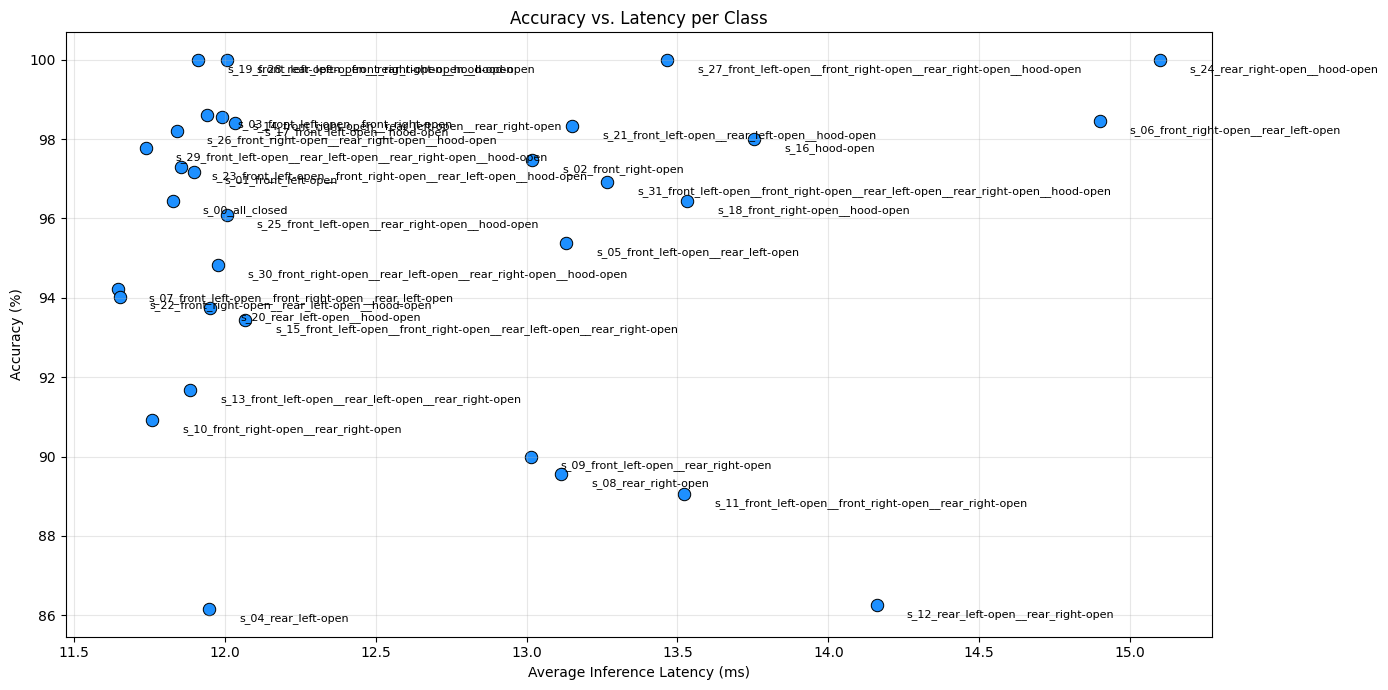

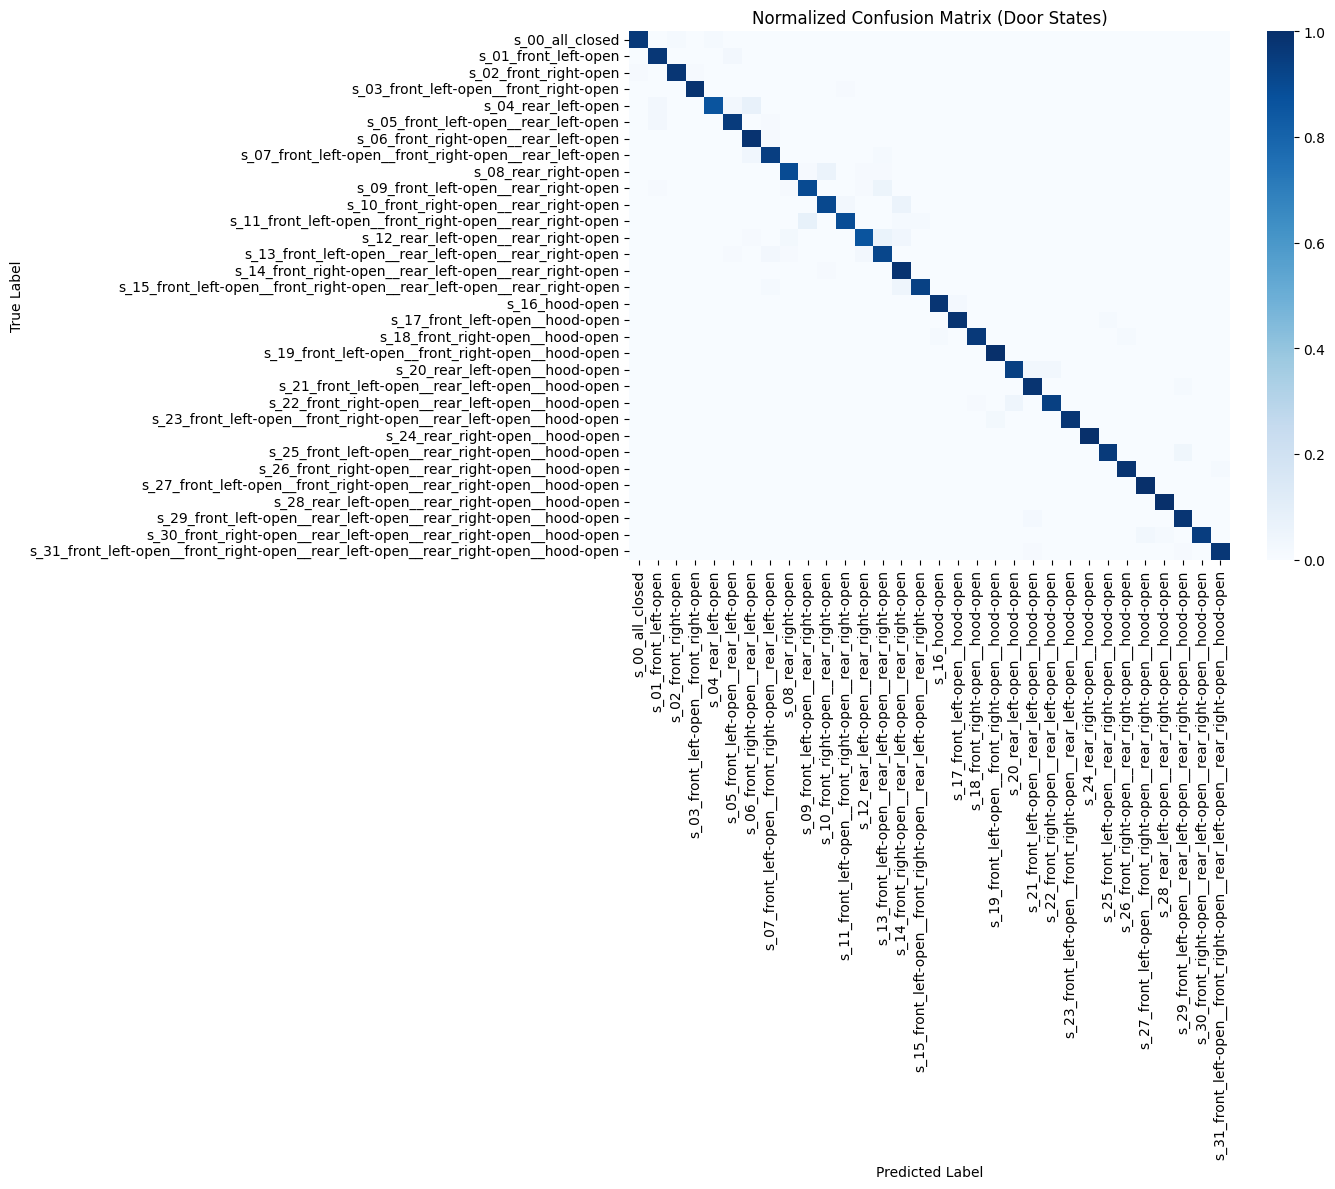


💾 Plots saved as:
   • confusion_matrix_doorstate_latency.png
   • doorstate_accuracy_vs_latency.png


In [20]:
import torch, os, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# ==========================================================
# CONFIG
# ==========================================================
MODEL_PATH = "door_state_cnn_final_script.pt"
DATA_DIR = "dataset"
IMG_SIZE = 348
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🧩 Using device: {DEVICE}")

# ==========================================================
# LOAD MODEL
# ==========================================================
print(f"🔹 Loading model from {MODEL_PATH} ...")
model = torch.jit.load(MODEL_PATH, map_location=DEVICE)
model.eval().to(DEVICE)
print("✅ TorchScript model loaded and ready.")

# ==========================================================
# DATASET
# ==========================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(dataset.classes)
print(f"📦 Validation set: {len(dataset)} images | Classes: {num_classes}")

# Split 80/20 again (same as training)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================================
# INFERENCE + LATENCY BENCHMARK
# ==========================================================
all_preds, all_labels = [], []
latencies, label_times = [], {i: [] for i in range(num_classes)}

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        start_time = time.time()
        outputs = model(imgs)
        torch.cuda.synchronize() if DEVICE == "cuda" else None
        end_time = time.time()

        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        latency_batch = (end_time - start_time) / len(imgs)
        latencies.extend([latency_batch] * len(imgs))

        # Track latency by class
        for lbl in labels.cpu().numpy():
            label_times[lbl].append(latency_batch)

# ==========================================================
# OVERALL PERFORMANCE
# ==========================================================
acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
avg_latency = np.mean(latencies) * 1000
min_latency = np.min(latencies) * 1000
max_latency = np.max(latencies) * 1000
fps = 1000 / avg_latency

print(f"\n✅ Validation Accuracy: {acc:.2f}%")
print(f"⚙️ Inference Performance:")
print(f"   • Avg Inference Time: {avg_latency:.2f} ms / image")
print(f"   • Fastest: {min_latency:.2f} ms | Slowest: {max_latency:.2f} ms")
print(f"   • Approx FPS: {fps:.1f}")

# ==========================================================
# PER-CLASS ANALYSIS
# ==========================================================
cm = confusion_matrix(all_labels, all_preds)
class_acc = cm.diagonal() / cm.sum(axis=1)
class_latency = [np.mean(label_times[i]) * 1000 if label_times[i] else 0 for i in range(num_classes)]

class_summary = pd.DataFrame({
    "Class": dataset.classes,
    "Accuracy (%)": np.round(class_acc * 100, 2),
    "Avg Latency (ms)": np.round(class_latency, 3)
}).sort_values("Accuracy (%)", ascending=False)

print("\n📊 Per-Class Latency and Accuracy Summary:")
print(class_summary.to_string(index=False))
class_summary.to_csv("doorstate_latency_per_class.csv", index=False)
print("\n💾 Saved per-class latency report → doorstate_latency_per_class.csv")

# ==========================================================
# VISUALIZATION: Accuracy vs Latency
# ==========================================================
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=class_summary,
    x="Avg Latency (ms)", y="Accuracy (%)",
    s=80, color="dodgerblue", edgecolor="black"
)
for i, row in class_summary.iterrows():
    plt.text(row["Avg Latency (ms)"]+0.1, row["Accuracy (%)"]-0.3, row["Class"], fontsize=8)
plt.title("Accuracy vs. Latency per Class")
plt.xlabel("Average Inference Latency (ms)")
plt.ylabel("Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("doorstate_accuracy_vs_latency.png", dpi=300)
plt.show()

# ==========================================================
# CONFUSION MATRIX
# ==========================================================
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Normalized Confusion Matrix (Door States)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_doorstate_latency.png", dpi=300)
plt.show()

print("\n💾 Plots saved as:")
print("   • confusion_matrix_doorstate_latency.png")
print("   • doorstate_accuracy_vs_latency.png")

🧩 Using device: cuda
🔹 Loading model from door_state_cnn_final_script.pt ...
✅ TorchScript model loaded and ready.
📦 Validation set: 9990 images | Classes: 32

✅ Validation Accuracy: 95.85%
⚙️ Inference Performance:
   • Avg Inference Time: 11.83 ms / image
   • Fastest: 8.34 ms | Slowest: 105.56 ms
   • Approx FPS: 84.5

📊 Per-Class Latency and Accuracy Summary:
                                                                             Class  Accuracy (%)  Avg Latency (ms)
                                  s_25_front_left-open__rear_right-open__hood-open        100.00            11.192
                                                             s_02_front_right-open        100.00            10.957
                                            s_03_front_left-open__front_right-open        100.00            12.476
                                                  s_18_front_right-open__hood-open        100.00            11.021
                                   s_28_rear_left-open__rea

/tmp/ipykernel_41/1288046995.py:142: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_41/1288046995.py:143: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig("doorstate_accuracy_vs_latency_outliers.png", dpi=300)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


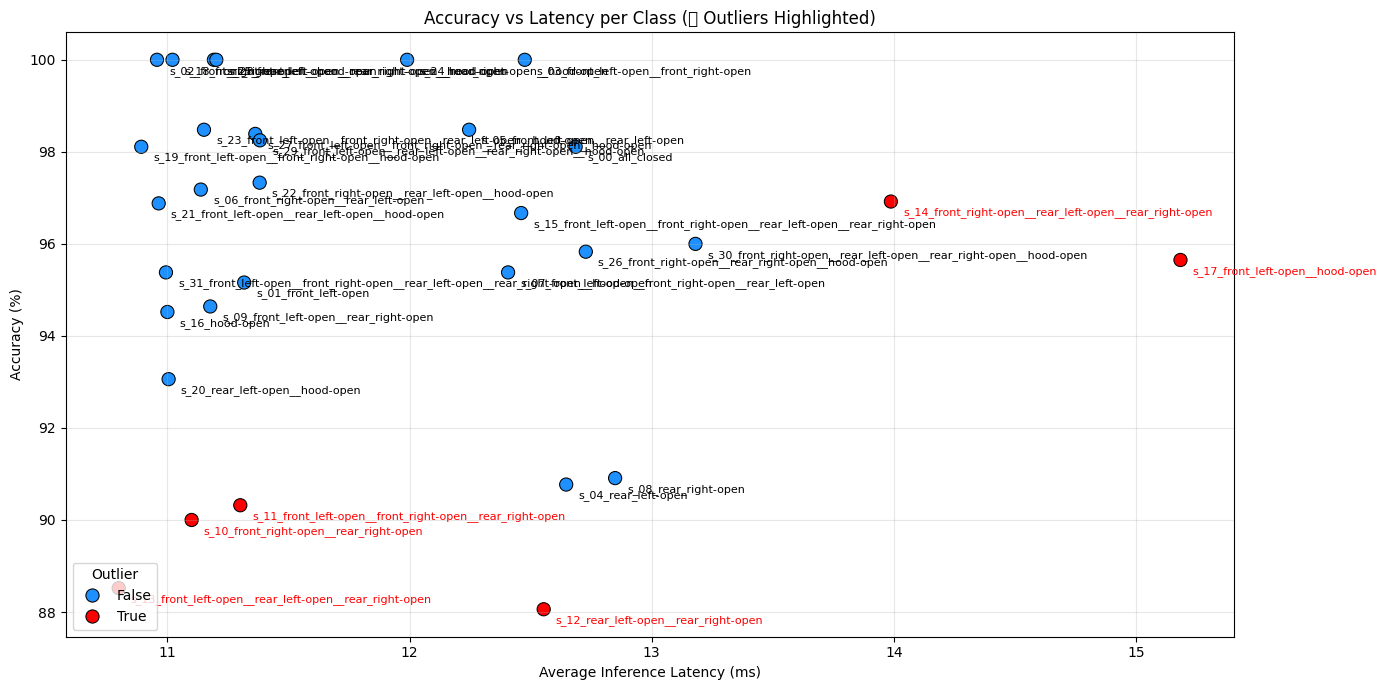

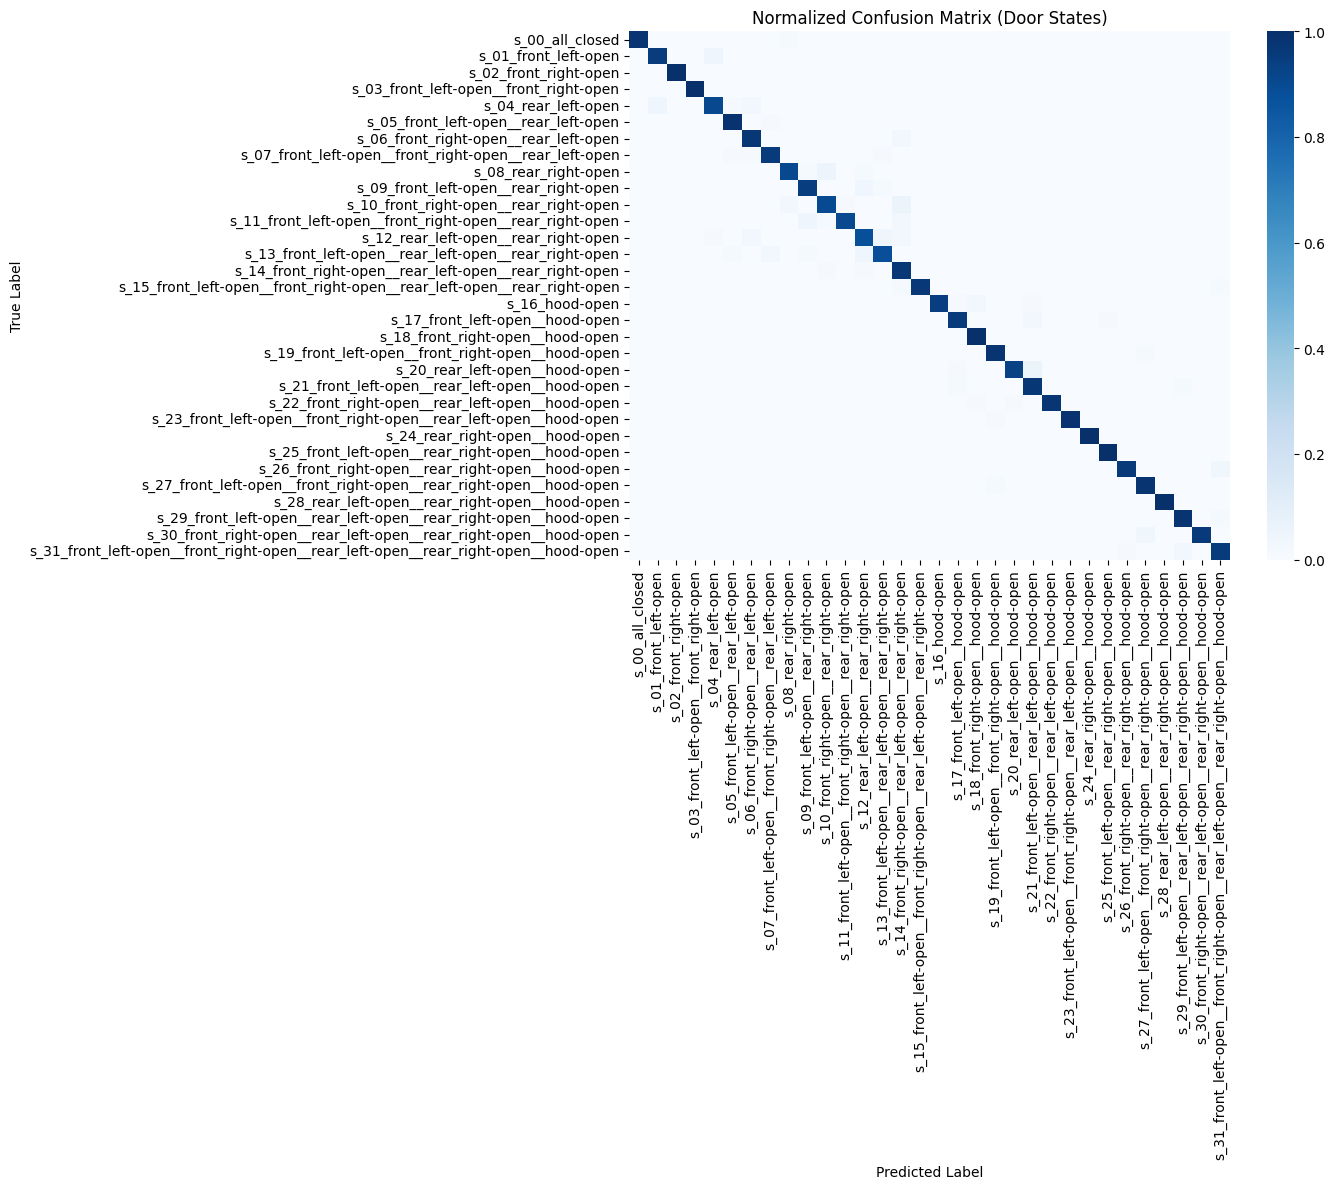


💾 Saved plots:
   • confusion_matrix_doorstate_latency.png
   • doorstate_accuracy_vs_latency_outliers.png


In [21]:
import torch, os, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# ==========================================================
# CONFIG
# ==========================================================
MODEL_PATH = "door_state_cnn_final_script.pt"
DATA_DIR = "dataset"
IMG_SIZE = 348
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🧩 Using device: {DEVICE}")

# ==========================================================
# LOAD MODEL
# ==========================================================
print(f"🔹 Loading model from {MODEL_PATH} ...")
model = torch.jit.load(MODEL_PATH, map_location=DEVICE)
model.eval().to(DEVICE)
print("✅ TorchScript model loaded and ready.")

# ==========================================================
# DATASET
# ==========================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(dataset.classes)
print(f"📦 Validation set: {len(dataset)} images | Classes: {num_classes}")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================================
# INFERENCE + LATENCY BENCHMARK
# ==========================================================
all_preds, all_labels = [], []
latencies, label_times = [], {i: [] for i in range(num_classes)}

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        start_time = time.time()
        outputs = model(imgs)
        torch.cuda.synchronize() if DEVICE == "cuda" else None
        end_time = time.time()

        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        latency_batch = (end_time - start_time) / len(imgs)
        latencies.extend([latency_batch] * len(imgs))

        for lbl in labels.cpu().numpy():
            label_times[lbl].append(latency_batch)

# ==========================================================
# PERFORMANCE METRICS
# ==========================================================
acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
avg_latency = np.mean(latencies) * 1000
min_latency = np.min(latencies) * 1000
max_latency = np.max(latencies) * 1000
fps = 1000 / avg_latency

print(f"\n✅ Validation Accuracy: {acc:.2f}%")
print(f"⚙️ Inference Performance:")
print(f"   • Avg Inference Time: {avg_latency:.2f} ms / image")
print(f"   • Fastest: {min_latency:.2f} ms | Slowest: {max_latency:.2f} ms")
print(f"   • Approx FPS: {fps:.1f}")

# ==========================================================
# PER-CLASS METRICS
# ==========================================================
cm = confusion_matrix(all_labels, all_preds)
class_acc = cm.diagonal() / cm.sum(axis=1)
class_latency = [np.mean(label_times[i]) * 1000 if label_times[i] else 0 for i in range(num_classes)]

class_summary = pd.DataFrame({
    "Class": dataset.classes,
    "Accuracy (%)": np.round(class_acc * 100, 2),
    "Avg Latency (ms)": np.round(class_latency, 3)
}).sort_values("Accuracy (%)", ascending=False)

print("\n📊 Per-Class Latency and Accuracy Summary:")
print(class_summary.to_string(index=False))
class_summary.to_csv("doorstate_latency_per_class.csv", index=False)
print("\n💾 Saved per-class latency report → doorstate_latency_per_class.csv")

# ==========================================================
# OUTLIER DETECTION
# ==========================================================
acc_mean, acc_std = class_summary["Accuracy (%)"].mean(), class_summary["Accuracy (%)"].std()
lat_mean, lat_std = class_summary["Avg Latency (ms)"].mean(), class_summary["Avg Latency (ms)"].std()

slow_threshold = lat_mean + 1.5 * lat_std
lowacc_threshold = acc_mean - 1.5 * acc_std

print(f"\n🔍 Outlier detection thresholds → Slow > {slow_threshold:.2f} ms | Low Acc < {lowacc_threshold:.2f}%")

# Mark outliers
class_summary["is_outlier"] = (
    (class_summary["Accuracy (%)"] < lowacc_threshold) |
    (class_summary["Avg Latency (ms)"] > slow_threshold)
)

# ==========================================================
# VISUALIZATION: Accuracy vs Latency
# ==========================================================
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=class_summary,
    x="Avg Latency (ms)", y="Accuracy (%)",
    hue="is_outlier", palette={True: "red", False: "dodgerblue"},
    s=90, edgecolor="black"
)

for _, row in class_summary.iterrows():
    color = "red" if row["is_outlier"] else "black"
    plt.text(row["Avg Latency (ms)"]+0.05, row["Accuracy (%)"]-0.3, row["Class"], fontsize=8, color=color)

plt.title("Accuracy vs Latency per Class (🔥 Outliers Highlighted)")
plt.xlabel("Average Inference Latency (ms)")
plt.ylabel("Accuracy (%)")
plt.legend(title="Outlier", loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("doorstate_accuracy_vs_latency_outliers.png", dpi=300)
plt.show()

# ==========================================================
# CONFUSION MATRIX
# ==========================================================
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=False, cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Normalized Confusion Matrix (Door States)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_doorstate_latency.png", dpi=300)
plt.show()

print("\n💾 Saved plots:")
print("   • confusion_matrix_doorstate_latency.png")
print("   • doorstate_accuracy_vs_latency_outliers.png")